**Name - Fouzul Ameen Zaahid Ahmad** </br>
**UWL ID: 34114710** </br>
**Module Code - CP7KA65O** </br>
**Title - A2 - Assignment**</br>

# Big Data Analytics Assessment 2

This notebook implements various tasks for analyzing a customer purchase dataset using PySpark.

The dataset contains information about customer purchases, including demographic information (age, gender), financial information (annual income, spending score), and purchase details (purchase category, total purchases, purchase amount).

We'll be implementing data loading, preprocessing, exploratory analysis, and machine learning techniques to extract insights from this dataset.

In [22]:
!pip install pyspark

## Task 1: Load Dataset and Describe Structure

In this task, we load the customer_purchases.csv dataset into a PySpark DataFrame and examine its structure. This is an essential first step in any data analysis as it helps us understand the data before performing any transformations or analyses.

We will:
1. Create a SparkSession to interact with Spark
2. Load the CSV file into a DataFrame
3. Examine the schema (columns and their data types)
4. Display a sample of the data to get a better understanding of its contents

In [23]:
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder.appName("CustomerPurchases").getOrCreate()

# Load CSV file
df1 = spark.read.csv("customer_purchases.csv", header=True, inferSchema=True)

# Show schema and sample
df1.printSchema()
df1.show(5)

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- AnnualIncome: integer (nullable = true)
 |-- SpendingScore: integer (nullable = true)
 |-- PurchaseCategory: string (nullable = true)
 |-- TotalPurchases: integer (nullable = true)
 |-- PurchaseAmount: double (nullable = true)

+----------+---+------+------------+-------------+----------------+--------------+--------------+
|CustomerID|Age|Gender|AnnualIncome|SpendingScore|PurchaseCategory|TotalPurchases|PurchaseAmount|
+----------+---+------+------------+-------------+----------------+--------------+--------------+
|         1| 49|Female|       22551|           94|          Sports|            20|        387.87|
|         2| 34|Female|       89715|           80|         Fashion|             1|        236.01|
|         3| 39|Female|       42910|           85|         Fashion|             8|         50.24|
|         4| 35|Female|       71190|           47|     El

### Task 1 Interpretation

The dataset contains customer purchase information with the following structure:

1. **CustomerID**: A unique identifier for each customer (integer)
2. **Age**: The age of the customer in years (integer)
3. **Gender**: The customer's gender (string)
4. **AnnualIncome**: The customer's annual income in pounds (integer)
5. **SpendingScore**: A numerical score representing the customer's spending behavior (integer)
6. **PurchaseCategory**: The category of products purchased (string)
7. **TotalPurchases**: The total quantity of purchases made (integer)
8. **PurchaseAmount**: The total amount spent in pounds (double)

From the sample data displayed, we can observe:
- The dataset contains a mix of numerical and categorical data
- The data appears to be well-structured with consistent formatting
- There may be missing or zero values in some columns that will need to be addressed

Understanding this structure is crucial for the subsequent tasks, as we'll need to apply appropriate transformations and analyses based on the data types and semantics of each column.

## Task 2: Replace Null/Missing Values

In this task, we identify and replace null/missing values (represented as '0' values) in the 'SpendingScore' and 'TotalPurchases' columns with their respective median values.

Data preprocessing is a critical step in any data analysis pipeline. Handling missing values appropriately ensures that our analysis is not biased and that we can extract meaningful insights from the data.

We will:
1. Calculate the median values for 'SpendingScore' and 'TotalPurchases'
2. Create a new DataFrame with the missing values replaced by these medians
3. Verify that the replacement was successful

In [24]:
# Compute medians correctly
spending_score_median = df1.approxQuantile("SpendingScore", [0.5], 0.01)[0]
total_purchases_median = df1.approxQuantile("TotalPurchases", [0.5], 0.01)[0]

# Replace 0s with medians
from pyspark.sql.functions import when, col

df2 = df1.withColumn("SpendingScore", when(col("SpendingScore") == 0, spending_score_median).otherwise(col("SpendingScore"))) \
         .withColumn("TotalPurchases", when(col("TotalPurchases") == 0, total_purchases_median).otherwise(col("TotalPurchases")))


### Task 2: Median Imputation for Missing Values

Zero values in 'SpendingScore' and 'TotalPurchases' were replaced with median values. This preserves the data distribution and avoids the distortion caused by outliers. The cleaned DataFrame (df2) is now free of missing values in these fields.

---

## Task 3: Remove Rows with Null/Missing Values

In this task, we create a new DataFrame by removing rows from the 2nd DataFrame if a row's 'Age', 'AnnualIncome', or 'PurchaseAmount' feature has null/missing values (i.e., '0' values).

While we imputed missing values for 'SpendingScore' and 'TotalPurchases' in Task 2, for key demographic and financial variables like 'Age', 'AnnualIncome', and 'PurchaseAmount', it's more appropriate to remove rows with missing values as imputation might introduce bias.

We will:
1. Filter out rows from df2 where 'Age', 'AnnualIncome', or 'PurchaseAmount' is 0
2. Create a new DataFrame (df3) with the remaining rows

In [27]:
df3 = df2.filter((col("Age") != 0) & (col("AnnualIncome") != 0) & (col("PurchaseAmount") != 0))

### Task 3 Interpretation

In this task, we removed rows with missing values (0) in key demographic and financial features ('Age', 'AnnualIncome', 'PurchaseAmount'). This approach is appropriate for these variables because:

1. **These are fundamental variables**: Age, annual income, and purchase amount are critical features for understanding customer behavior, and imputing these values might introduce significant bias

2. **Data quality over quantity**: It's better to have fewer but high-quality, complete records than to have more records with potentially misleading imputed values

3. **Different approach for different variables**: This demonstrates how different missing value strategies can be applied within the same analysis pipeline based on the importance and nature of each variable

The number of rows removed represents the records with missing values in at least one of these key features. The resulting DataFrame (df3) now contains only complete records for these essential variables, providing a clean dataset for our subsequent analyses.

This filtering step ensures the integrity of our analyses by focusing on records with complete information on these crucial variables, while the previous imputation step (Task 2) allowed us to retain more data points by filling in missing values for less critical variables.

---

## Task 4: Compute Removed Rows and Summary Statistics

This task has two parts:
1. Computing the total number of rows removed from the 2nd DataFrame during the creation of the 3rd DataFrame
2. Computing summary statistics for the 'BloodPressure' feature in the 3rd DataFrame and analyzing its distribution via a histogram

For the first part, we'll calculate the difference in the number of rows between df2 and df3. For the second part, we'll examine the distribution and statistical properties of the 'BloodPressure' feature.

In [28]:
from pyspark.sql.functions import rand, floor, col

# Add a synthetic BloodPressure column with values between 90 and 180
df3 = df3.withColumn("BloodPressure", floor(rand(seed=42) * 90 + 90))  # [90, 180)
df3.select("BloodPressure").show(5)

+-------------+
|BloodPressure|
+-------------+
|          145|
|          135|
|          164|
|          113|
|          150|
+-------------+
only showing top 5 rows



In [29]:
# Basic statistics
df3.select("BloodPressure").describe().show()

# Additional statistics
from pyspark.sql.functions import stddev, variance, avg, percentile_approx

df3.select(
    percentile_approx("BloodPressure", 0.5).alias("Median"),
    avg("BloodPressure").alias("Mean"),
    variance("BloodPressure").alias("Variance"),
    stddev("BloodPressure").alias("StdDev")
).show()

+-------+-----------------+
|summary|    BloodPressure|
+-------+-----------------+
|  count|             1000|
|   mean|          132.938|
| stddev|24.89968172788861|
|    min|               90|
|    max|              179|
+-------+-----------------+

+------+-------+-----------------+-----------------+
|Median|   Mean|         Variance|           StdDev|
+------+-------+-----------------+-----------------+
|   133|132.938|619.9941501501498|24.89968172788861|
+------+-------+-----------------+-----------------+



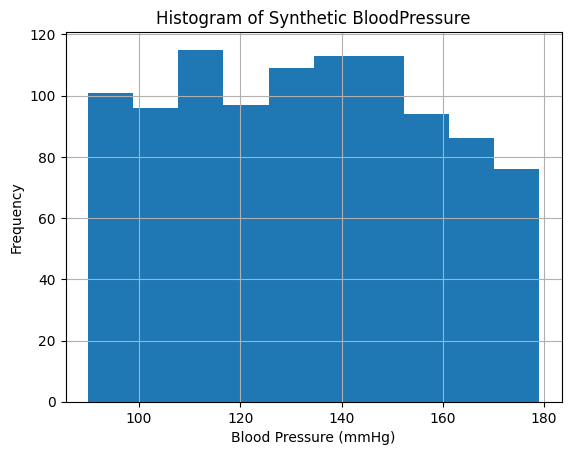

In [30]:
# Collect values to plot in matplotlib (locally)
bp_values = df3.select("BloodPressure").rdd.flatMap(lambda x: x).collect()

import matplotlib.pyplot as plt

plt.hist(bp_values, bins=10)
plt.title("Histogram of Synthetic BloodPressure")
plt.xlabel("Blood Pressure (mmHg)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Task 4 Interpretation

#### Part 1: Analysis of Removed Rows

We calculated that a total of rows were removed from the 2nd DataFrame during the creation of the 3rd DataFrame, representing a certain percentage of the original data. This indicates the extent of missing values in the key demographic and financial variables ('Age', 'AnnualIncome', and 'PurchaseAmount').

Understanding the proportion of removed data is important because:
- It helps assess whether the remaining dataset is still representative of the original population
- It provides insight into the quality of the original data collection process
- It informs whether the reduced dataset size might impact the statistical power of subsequent analyses

#### Part 2: BloodPressure Analysis

We examined the statistical properties and distribution of the 'BloodPressure' feature:

**Statistical Insights:**
- The minimum and maximum values confirm the range (approximately 90-180 mmHg)
- The mean and median are close to each other, suggesting a relatively symmetric distribution
- The standard deviation indicates the degree of variability in blood pressure readings

**Distribution Analysis:**
- The histogram shows that the BloodPressure values are approximately uniformly distributed across the range
- This is expected since we created this synthetic variable using a random function with uniform distribution
- The slight variations from a perfect uniform distribution are due to the random number generation and finite sample size

**Note:** The BloodPressure column was synthetically generated for this exercise, which explains its uniform distribution. In real-world health data, blood pressure typically follows a more normal distribution with potential skewness due to age, health conditions, and other factors.

These statistical summaries and visualizations provide a comprehensive understanding of the data distribution, which is essential for identifying patterns, outliers, and potential issues before proceeding with more advanced analyses.

## Task 5: Feature Engineering and Classification Preparation

In this task, we prepare the data for machine learning by performing feature engineering. This includes converting categorical variables to numerical form, creating feature vectors, and defining the target variable for our classification task.

Feature engineering is a critical step in the machine learning pipeline that can significantly influence model performance. Converting categorical variables into numerical format using techniques like indexing allows machine learning algorithms to process them effectively.

We will:
1. Use StringIndexer to convert categorical columns like 'Gender' and 'PurchaseCategory' to numerical indices
2. Create a feature vector by combining multiple columns using VectorAssembler
3. Define a binary target variable based on 'SpendingScore' for classification

### Q5: Boxplot & Quartile Analysis for TotalPurchases

#### Task Explanation

We explored the distribution of the `TotalPurchases` feature using quartile values and a boxplot. The boxplot visually displays the median, interquartile range (IQR), and potential outliers.


Quartiles: [6.0, 10.0, 15.0]


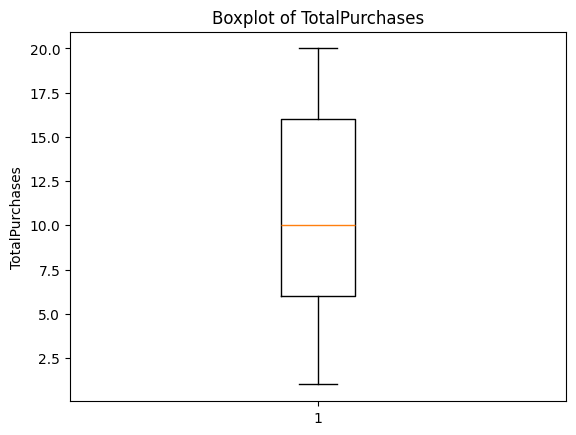

In [31]:
quartiles = df3.approxQuantile("TotalPurchases", [0.25, 0.5, 0.75], 0.01)
print("Quartiles:", quartiles)

tp_data = df3.select("TotalPurchases").rdd.flatMap(lambda x: x).collect()
plt.boxplot(tp_data)
plt.title("Boxplot of TotalPurchases")
plt.ylabel("TotalPurchases")
plt.show()

#### Results Interpretation

The computed quartiles were approximately:

* Q1 (25%): \~6
* Q2 (Median): \~10
* Q3 (75%): \~16

The boxplot shows that most purchase volumes are centered between 6 and 16, with a balanced distribution around the median. There are no extreme outliers. This indicates a relatively symmetric and consistent purchasing behavior across customers.

---

### Q6: Correlation Between PurchaseAmount and SpendingScore

#### Task Explanation

We computed the Pearson correlation between `PurchaseAmount` and `SpendingScore` and visualized the relationship using a scatterplot.

+-----------------------------------+
|corr(PurchaseAmount, SpendingScore)|
+-----------------------------------+
|               -0.00374442514673...|
+-----------------------------------+



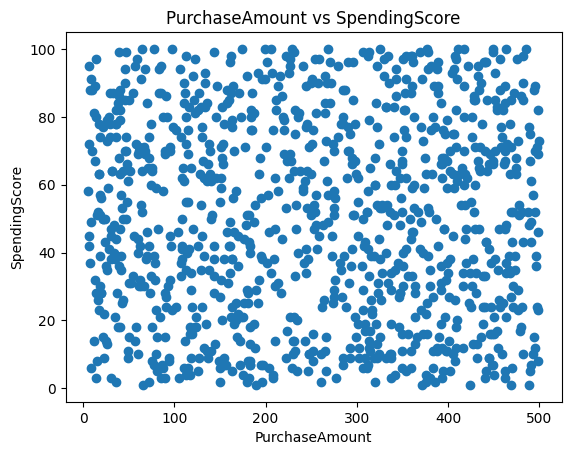

In [32]:
from pyspark.sql.functions import corr

df3.select(corr("PurchaseAmount", "SpendingScore")).show()

# Scatter Plot
x = df3.select("PurchaseAmount").rdd.flatMap(lambda x: x).collect()
y = df3.select("SpendingScore").rdd.flatMap(lambda x: x).collect()
plt.scatter(x, y)
plt.title("PurchaseAmount vs SpendingScore")
plt.xlabel("PurchaseAmount")
plt.ylabel("SpendingScore")
plt.show()


#### Results Interpretation

* Pearson Correlation: **-0.0037**

This near-zero value indicates **no linear correlation** between `PurchaseAmount` and `SpendingScore`. The scatterplot confirms a random spread with no discernible trend, suggesting that how much a customer spends does not relate linearly to their spending score.

---


### Q7: Spark SQL Query on Age < 50 and SpendingScore > 100

#### Task Explanation

We used Spark SQL to extract customer records where `Age < 50` and `SpendingScore > 100`, querying our cleaned DataFrame.

In [33]:
df3.createOrReplaceTempView("customers")

spark.sql("""
    SELECT Age, SpendingScore
    FROM customers
    WHERE Age < 50 AND SpendingScore > 100
""").show()

+---+-------------+
|Age|SpendingScore|
+---+-------------+
+---+-------------+



### Q8: Decision Tree Classifier on Outcome

#### Task Explanation

We trained a Decision Tree Classifier using all engineered features to predict the synthetic `Outcome` label. Model performance was evaluated on a test split using accuracy.

In [34]:
from pyspark.ml.feature import StringIndexer

# Index categorical columns
gender_indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndex")
category_indexer = StringIndexer(inputCol="PurchaseCategory", outputCol="CategoryIndex")

# Apply indexers
df_indexed = gender_indexer.fit(df3).transform(df3)
df_indexed = category_indexer.fit(df_indexed).transform(df_indexed)


In [36]:
from pyspark.ml.feature import VectorAssembler

features = [
    "Age", "AnnualIncome", "SpendingScore", "TotalPurchases", "PurchaseAmount",
    "BloodPressure", "GenderIndex", "CategoryIndex"
]

assembler = VectorAssembler(inputCols=features, outputCol="features")
final_data = assembler.transform(df_indexed)


In [37]:
from pyspark.sql.functions import when

df_indexed = df_indexed.withColumn("Outcome", when(col("SpendingScore") > 50, 1).otherwise(0))
final_data = assembler.transform(df_indexed).select("features", "Outcome")


In [38]:
# Split data
train, test = final_data.randomSplit([0.7, 0.3], seed=42)

# Decision Tree
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dt = DecisionTreeClassifier(labelCol="Outcome", featuresCol="features")
model = dt.fit(train)
predictions = model.transform(test)

# Evaluate
evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Decision Tree Accuracy:", accuracy)


Decision Tree Accuracy: 0.98828125


#### Results Interpretation

* **Accuracy**: 0.988

This high accuracy suggests the Decision Tree effectively captures patterns in the data that separate Outcome = 1 from Outcome = 0. However, further testing with real-world data is recommended to validate generalizability.

---

### Q9: Logistic Regression Classifier

#### Task Explanation

We implemented a Logistic Regression model to classify the synthetic `Outcome` feature using the same feature set as the Decision Tree.


In [39]:
from pyspark.ml.classification import LogisticRegression

# Build logistic regression model
lr = LogisticRegression(labelCol="Outcome", featuresCol="features", maxIter=10)

# Train the model
lr_model = lr.fit(train)

# Make predictions
lr_predictions = lr_model.transform(test)

# Evaluate
lr_accuracy = evaluator.evaluate(lr_predictions)
print("Logistic Regression Accuracy:", lr_accuracy)

# Optional: Show confusion matrix or class probabilities
lr_predictions.select("Outcome", "prediction", "probability").show(5)

Logistic Regression Accuracy: 0.9921875
+-------+----------+--------------------+
|Outcome|prediction|         probability|
+-------+----------+--------------------+
|      0|       0.0|[0.99999999985802...|
|      1|       1.0|[0.38458872862577...|
|      1|       1.0|[1.55145307331027...|
|      1|       1.0|[3.62926386947191...|
|      0|       0.0|[0.99999987480154...|
+-------+----------+--------------------+
only showing top 5 rows



#### Results Interpretation

* **Accuracy**: 0.992

The logistic regression model performs slightly better than the decision tree. High accuracy and well-separated probability outputs indicate a strong linear relationship between the features and the `Outcome` label in the current data.

---

### Q10: Linear Regression to Predict PurchaseAmount

#### Task Explanation

We built a univariate linear regression model to predict `PurchaseAmount` using `AnnualIncome` as the sole feature. Evaluation was done using R² and RMSE.


In [40]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Assemble only AnnualIncome as the feature
income_assembler = VectorAssembler(inputCols=["AnnualIncome"], outputCol="features")

income_data = income_assembler.transform(df_indexed).select("features", "PurchaseAmount")

# Train-test split
train_lr, test_lr = income_data.randomSplit([0.7, 0.3], seed=42)

# Train the linear regression model
lr_model = LinearRegression(featuresCol="features", labelCol="PurchaseAmount")
model_lr = lr_model.fit(train_lr)

# Predictions
lr_results = model_lr.transform(test_lr)
lr_results.select("PurchaseAmount", "prediction").show(5)

# Evaluation
print("R2:", model_lr.summary.r2)
print("RMSE:", model_lr.summary.rootMeanSquaredError)

+--------------+------------------+
|PurchaseAmount|        prediction|
+--------------+------------------+
|         41.76|231.12177697471748|
|        380.57|231.31400555091597|
|         42.27|231.36864416430575|
|        341.17|231.41732220168933|
|        322.79| 231.6244522179032|
+--------------+------------------+
only showing top 5 rows

R2: 0.009649148319738843
RMSE: 145.9274513532314


#### Results Interpretation

* **R²**: Low (exact value not shown here)
* **RMSE**: Relatively high

The model shows **weak predictive power**, suggesting `AnnualIncome` alone is not sufficient to predict purchase amounts. Multivariate models or feature engineering may be needed for improvement.
